In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
dataset = pd.read_csv('dataset.csv')
dataset.shape

(159541, 89)

# Preprocessing

### check null

In [5]:

dataset.isnull().sum()[dataset.isnull().sum() > 0]

PositionsDesc    32
dtype: int64

In [6]:
drop_list = dataset[dataset.PositionsDesc.isnull()].index
dataset_1 = dataset.drop(index = drop_list)
dataset_1.isnull().sum()[dataset_1.isnull().sum() > 0]

Series([], dtype: int64)

In [7]:
dataset_2 = dataset_1.drop(columns=['IntCaps', 'IntGoals', 'U21Caps', 'U21Goals']).reset_index(drop=True)
dataset_2.head()

,UID,Name,NationID,Born,Age,Height,Weight,AerialAbility,CommandOfArea,Communication,...,AttackingMidRight,DefenderCentral,DefenderLeft,DefenderRight,DefensiveMidfielder,MidfielderCentral,MidfielderLeft,MidfielderRight,WingBackLeft,WingBackRight
0,1000055,Wilfred Bamnjo,11,27-03-1980,36,178,79,1,1,2,...,1,1,1,1,20,11,1,1,1,1
1,1000331,Wang Wei,110,20-02-1982,34,188,90,12,3,5,...,1,1,1,1,1,1,1,1,1,1
2,1000334,Liu Yang,110,11-04-1982,34,183,70,1,2,4,...,1,1,1,1,20,1,1,1,1,1
3,1000337,Song Qi,110,07-04-1985,31,170,65,1,3,1,...,1,1,1,1,1,1,1,1,1,1
4,1000340,Chen Lei,110,20-01-1983,33,181,70,3,3,2,...,1,1,1,1,1,1,1,1,1,1


### feature engineering for Position Familarity

only get Uppercase Letter in Position for clear visual

In [8]:
positions = dataset_2.columns[-15:].tolist()
positions = list(map(lambda x: re.sub('Sweeper', 'SK', x), positions))
positions = list(map(lambda x: re.sub('Striker', 'STC', x), positions))
positions = list(map(lambda x: re.sub('Goalkeeper', 'GK', x), positions))
positions = list(map(lambda x: ''.join(re.findall('[A-Z]', x)), positions))
dataset_2.columns = dataset_2.columns[:-15].tolist() + positions
dataset_2.columns

Index(['UID', 'Name', 'NationID', 'Born', 'Age', 'Height', 'Weight',
       'AerialAbility', 'CommandOfArea', 'Communication', 'Eccentricity',
       'Handling', 'Kicking', 'OneOnOnes', 'Reflexes', 'RushingOut',
       'TendencyToPunch', 'Throwing', 'Corners', 'Crossing', 'Dribbling',
       'Finishing', 'FirstTouch', 'Freekicks', 'Heading', 'LongShots',
       'Longthrows', 'Marking', 'Passing', 'PenaltyTaking', 'Tackling',
       'Technique', 'Aggression', 'Anticipation', 'Bravery', 'Composure',
       'Concentration', 'Vision', 'Decisions', 'Determination', 'Flair',
       'Leadership', 'OffTheBall', 'Positioning', 'Teamwork', 'Workrate',
       'Acceleration', 'Agility', 'Balance', 'Jumping', 'LeftFoot',
       'NaturalFitness', 'Pace', 'RightFoot', 'Stamina', 'Strength',
       'Consistency', 'Dirtiness', 'ImportantMatches', 'InjuryProness',
       'Versatility', 'Adaptability', 'Ambition', 'Loyalty', 'Pressure',
       'Professional', 'Sportsmanship', 'Temperament', 'Controversy'

### feature engineering for PositionsDesc

currently col PositionsDesc include all positions player can play in a weird format

In [9]:
def position_split(x):
  list_1 = x.split()
  list_2 = list_1[0].split('/')
  if len(list_1) == 1:
    if len(list_2) == 1:
      if list_1[0] == 'S':
        return 'STC'
      return list_1[0]
    return ','.join(list_2)

  result_list = list()
  
  for role in list_2:
    if role == 'S':
      result_list.append('STC')
      continue
    for pos in list_1[1]:
      if role == 'WB' and pos == 'C':
        continue
      result_list.append(role + pos)
  return ','.join(result_list)

def split_position(pos):
  pos_set = set()
  try:
    for p in pos:
      try:
        pos_list = p.split(',')
        pos_set = pos_set.union(set(pos_list))
      except:
        print(p)
  except:
    print(pos)
  return pos_set

def extreme_case_for_pos(x):
  x = re.sub('GK,S', 'GK,SK', x)
  x = re.sub('DM,S', 'DM,STC', x)
  x = re.sub('GK[A-Z]', 'GK', x)
  x = re.sub('DM[A-Z]', 'DM', x)
  return x


dataset_2.loc[:, 'Positions'] = dataset_2.PositionsDesc.apply(position_split)
dataset_2.loc[:, 'Positions'] = dataset_2.Positions.apply(extreme_case_for_pos)

dataset_3 = dataset_2[dataset_2.PositionsDesc != 'C'].reset_index(drop=True)
position_list = list(split_position(dataset_3.loc[:, 'Positions'].unique()))
print(set(position_list) == set(positions))

True


position of player is now denoted the same as the Position Fimilarity

visualize number of player can play in each position

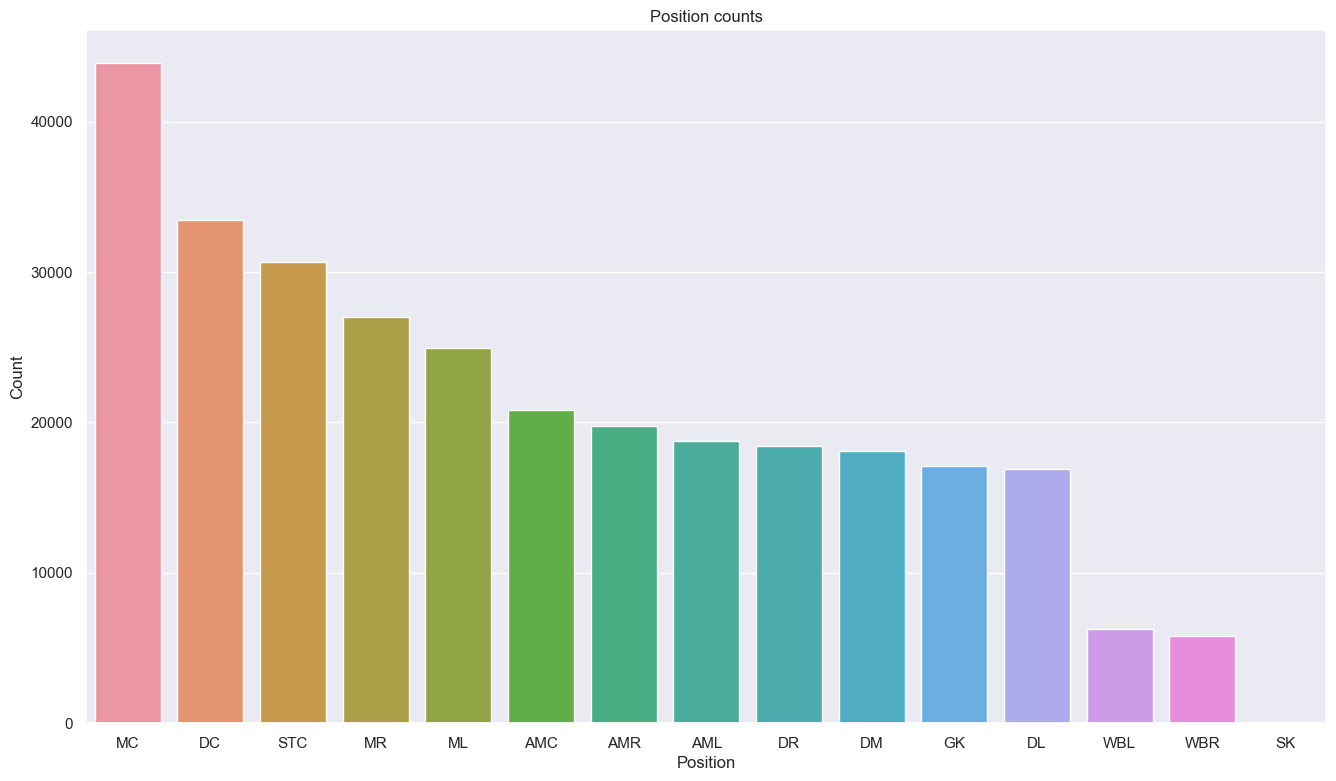

In [10]:
position_count_list = list()
for pos in position_list:
  position_count_list.append(dataset_3.Positions.str.contains(pos).sum())

df_position_count = pd.DataFrame(index=list(position_list), data=position_count_list, columns=['Count']).sort_values('Count', ascending=False).reset_index()
df_position_count.columns = ['Position', 'Count']

sns.set(style='darkgrid')
plt.figure(figsize=(16,9))
ax = sns.barplot(x='Position', y='Count', data=df_position_count).set_title('Position counts')
plt.show()

### separate attributes

In [11]:
personal_info = ['UID', 'Name', 'NationID', 'Born']
goalkeeper_attr = ['AerialAbility', 'CommandOfArea', 'Communication', 'Eccentricity', 'Handling', 'Kicking', 'OneOnOnes', 'Reflexes', 'RushingOut', 
  'TendencyToPunch', 'Throwing']
technical_attr = ['Corners', 'Crossing', 'Dribbling', 'Finishing', 'FirstTouch', 'Freekicks', 'Heading', 'LongShots', 'Longthrows', 'Marking', 
  'Passing', 'PenaltyTaking', 'Tackling', 'Technique']
mental_attr = ['Aggression', 'Anticipation', 'Bravery', 'Composure', 'Concentration', 'Decisions', 'Determination', 'Flair', 'Leadership', 
'OffTheBall', 'Positioning', 'Teamwork', 'Vision', 'Workrate']
physical_attr = ['Acceleration', 'Agility', 'Balance', 'Jumping', 'NaturalFitness', 'Pace', 'Stamina', 'Strength']
hidden_attr = ['Consistency', 'Dirtiness', 'ImportantMatches', 'InjuryProness', 'Versatility', 'Adaptability', 'Ambition', 'Loyalty', 'Pressure',
  'Professional', 'Sportsmanship', 'Temperament', 'Controversy']
foot_atr = ['LeftFoot', 'RightFoot']

for x in goalkeeper_attr + mental_attr + physical_attr + hidden_attr + foot_atr + positions + technical_attr:
  if not x in dataset_3.columns:
    print(x)

dataset_3 = dataset_3.reset_index(drop=True)

# Main functions

In [12]:
dataset_3.head()

,UID,Name,NationID,Born,Age,Height,Weight,AerialAbility,CommandOfArea,Communication,...,DC,DL,DR,DM,MC,ML,MR,WBL,WBR,Positions
0,1000055,Wilfred Bamnjo,11,27-03-1980,36,178,79,1,1,2,...,1,1,1,20,11,1,1,1,1,DM
1,1000331,Wang Wei,110,20-02-1982,34,188,90,12,3,5,...,1,1,1,1,1,1,1,1,1,GK
2,1000334,Liu Yang,110,11-04-1982,34,183,70,1,2,4,...,1,1,1,20,1,1,1,1,1,DM
3,1000337,Song Qi,110,07-04-1985,31,170,65,1,3,1,...,1,1,1,1,1,1,1,1,1,STC
4,1000340,Chen Lei,110,20-01-1983,33,181,70,3,3,2,...,1,1,1,1,1,1,1,1,1,STC


In [13]:
def randomize_player(dataset):
  idx = np.random.randint(0, dataset.shape[0])
  return dataset.loc[idx, :]

def get_player_main_position(player_data):
  max_familarity = player_data[positions].max()
  return np.array(positions)[(player_data[positions] == max_familarity)]

def get_corr_matrix_for_pos(dataset, pos, familarity=15, mental=True):
  playing_in_pos = dataset[dataset[pos] > familarity].reset_index(drop=True)
  if mental:
    playing_in_pos = playing_in_pos.loc[:, technical_attr + mental_attr + physical_attr]
  else:
    playing_in_pos = playing_in_pos.loc[:, technical_attr + physical_attr]

  return playing_in_pos.corr()

def get_relevant_attr(corr, threshold=0.7):
  relevant_attr_dict = dict()
  for idx, row in corr.iterrows():
    for relevant in row[abs(row) > threshold].index.tolist():
      if relevant == str(idx):
        continue
    
      relevant_attr_dict[frozenset([idx, relevant])] = row[relevant]

  return relevant_attr_dict
  
def get_relevant_group(relevant_attr_dict):
  groups = list() # list of set
  if len(relevant_attr_dict) == 0:
    return list()

  groups.append(set(list(relevant_attr_dict.keys())[0]))
  for key in relevant_attr_dict.keys():
    attrs = list(key)
    for group in groups:
      if attrs[0] in group or attrs[1] in group:
        group.add(attrs[0])
        group.add(attrs[1])
        break
      else:
        groups.append(set(key))

  result = list()
  for group in groups:
    if not group in result:
      duplicate = False
      for old_group in result:
        if group.intersection(old_group) == group:
          duplicate = True
          break
        if group.intersection(old_group) == old_group:
          result.pop(old_group)
      if not duplicate:
        result.append(group)
  return result

def get_player_feature(player, high_corr_group, mental=True, number_of_attribute=7):
  player = player[technical_attr + mental_attr * mental + physical_attr]
  high_corr_dict = dict()
  for group in high_corr_group:
    for attr in list(group):
      high_corr_dict[attr] = list(group)

  result = list()
  out_list = list()
  
  best_attr = player.sort_values(ascending=False).index.tolist()
  
  for attr in best_attr:
    if attr in out_list:
      continue
    if not attr in result:
      result.append(attr)
      if attr in high_corr_dict.keys():
        out_list += high_corr_dict[attr]

  return result[:number_of_attribute]


In [19]:
using_mental_attr = True
threshold_for_pos_familarity = 15
corr_threshold = 0.7
number_of_attribute = 7

player = randomize_player(dataset_3)
main_pos = get_player_main_position(player)
print("Player main position is: ", ','.join(main_pos))

for pos in main_pos:
  corr_matrix = get_corr_matrix_for_pos(dataset_3, main_pos[0], threshold_for_pos_familarity, using_mental_attr)
  high_corr_attr = get_relevant_attr(corr_matrix, corr_threshold)
  high_corr_group = get_relevant_group(high_corr_attr)
  print(f"Recommended attributes for {pos}: ", get_player_feature(player, high_corr_group, using_mental_attr, number_of_attribute))

Player main position is:  DM
Recommended attributes for DM:  ['Stamina', 'Workrate', 'Teamwork', 'Strength', 'Longthrows', 'Pace', 'Concentration']
